In [1]:
%load_ext watermark
%watermark -a Filippo_Valle -ppandas,numpy,seaborn,matplotlib,lifelines -g -m -r

Author: Filippo_Valle

pandas    : 1.3.3
numpy     : 1.19.5
seaborn   : 0.11.2
matplotlib: 3.5.1
lifelines : 0.26.4

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.13.0-28-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Git hash: 576214878cace9abdbc3f729d37bf445b11e12ff

Git repo: git@github.com:fvalle1/keywordTCGA.git



In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_dir = "brca"

## Survival

In [4]:
df_files = pd.read_csv("files.dat", sep=",", index_col=0).replace("unknown", np.nan)
df_files.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1092 entries, TCGA-3C-AAAU to TCGA-A2-A25C
Data columns (total 27 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   file_miRNA                                       1074 non-null   object
 1   cases.0.demographic.days_to_birth                1058 non-null   object
 2   cases.0.demographic.days_to_death                148 non-null    object
 3   cases.0.demographic.gender                       1073 non-null   object
 4   cases.0.demographic.vital_status                 1073 non-null   object
 5   cases.0.diagnoses.0.age_at_diagnosis             1058 non-null   object
 6   cases.0.diagnoses.0.days_to_last_follow_up       970 non-null    object
 7   cases.0.diagnoses.0.last_known_disease_status    1073 non-null   object
 8   cases.0.diagnoses.0.tumor_stage                  1073 non-null   object
 9   cases.0.project.project_id 

In [5]:
bins = np.linspace(0,100,20)
avg = df_files["cases.0.diagnoses.0.age_at_diagnosis"].astype(float).mean(skipna=True)
df_files["age_at_diagnosis"]=pd.cut(df_files["cases.0.diagnoses.0.age_at_diagnosis"].astype(float).fillna(avg)/365., bins=bins, labels = (bins[1:]+bins[:-1])/2).__array__()

In [6]:
df_files["gender"] = (df_files["cases.0.demographic.gender"]=="male").astype(int)

In [7]:
for letter in ["a", "b", "c"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
df_files["cases.0.diagnoses.0.tumor_stage"].unique()

array(['stage x', 'stage iii', 'stage i', 'stage ii', nan, 'stage iv',
       'not reported'], dtype=object)

In [8]:
df_files["tumor_stage"]=df_files["cases.0.diagnoses.0.tumor_stage"]
for i,stage in enumerate(["stage i", "stage ii", "stage iii", "stage iv", "stage v", "stage x"]):
    df_files["tumor_stage"].replace(stage, i+1, inplace=True)

In [9]:
#0 = Alive
df_files["vital_status"]=(df_files["cases.0.demographic.vital_status"]=="Dead").astype(int)

In [10]:
def get_survival(case):
    if case["cases.0.demographic.vital_status"] == 1:
        return case["cases.0.demographic.days_to_death"]
    else:
        return case["cases.0.diagnoses.0.days_to_last_follow_up"]

df_files["days_survival"] = df_files.apply(get_survival,1)

## Clusters

/opt/conda/lib/python3.8/site-packages/lifelines/plotting.py:710: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


*******Cluster 6 Z:2.854441119394784*******
0.18181818181818177 0.37679591836734694 0.06830679926251397


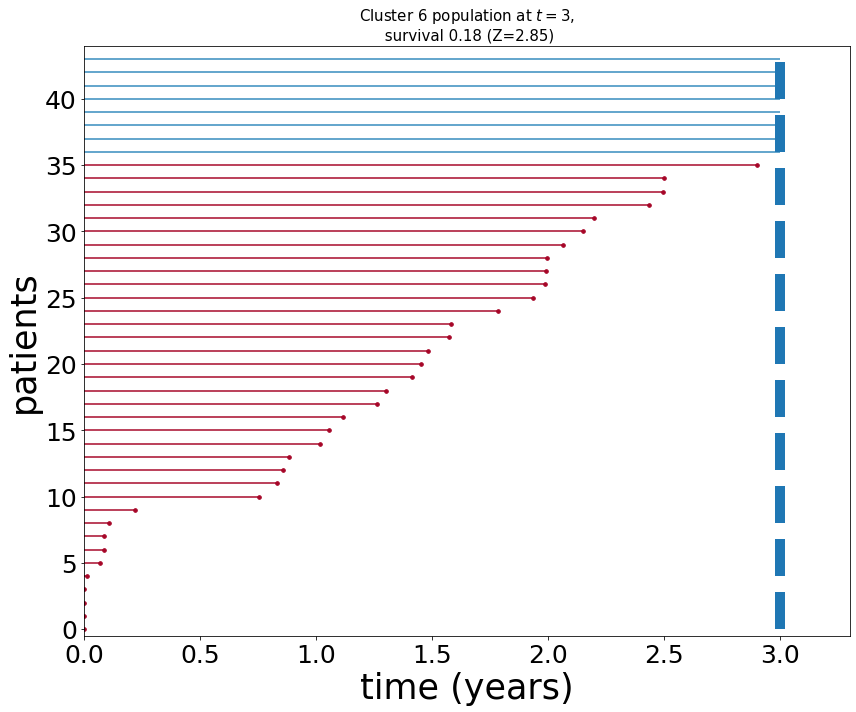

/opt/conda/lib/python3.8/site-packages/lifelines/plotting.py:710: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


*******Cluster 14 Z:3.6533003349425597*******
0.6 0.37818965517241376 0.0607150588485832


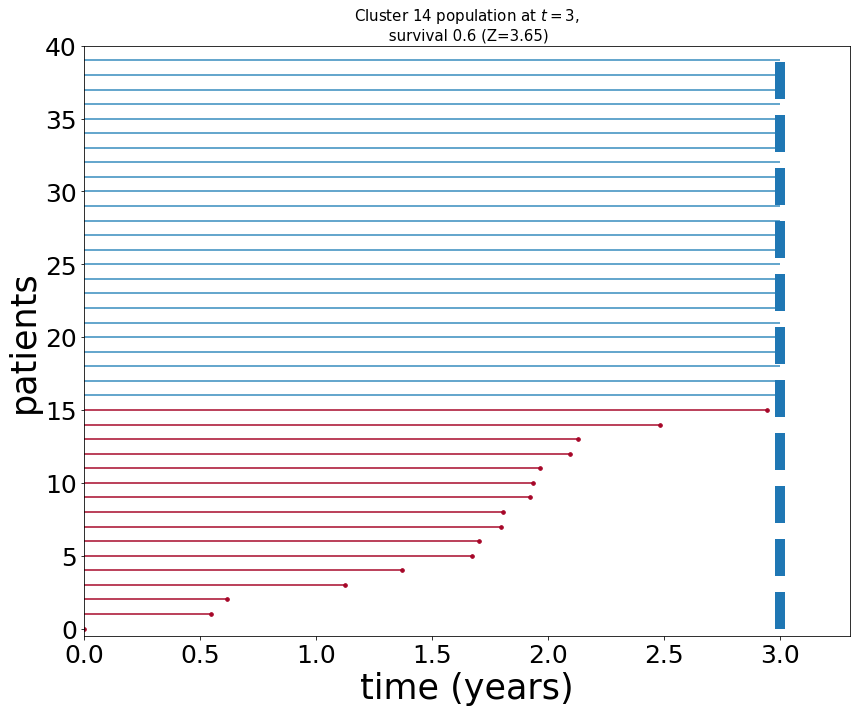

In [27]:
from lifelines.plotting import plot_lifetimes

l=0

for cluster in ["Cluster %d"%(c+1) for c in [5,13]]:
#for subtype in df_files["Subtype_Selected"].unique():
    subset = df_files[(~df_files["days_survival"].isna()) & (df_files["days_survival"]!="unknown") & df_files.index.isin(pd.read_csv(f"brca/trisbm/trisbm_level_{l}_clusters.csv")[cluster].dropna())]
    #subset = df_files[(~df_files["days_survival"].isna()) & (df_files["days_survival"]!="unknown") & (df_files["Subtype_Selected"]==subtype)]
    
    CURRENT_TIME = 3

    actual_lifetimes = subset["days_survival"].astype(float).to_numpy()/365
    observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
    death_observed = actual_lifetimes < CURRENT_TIME
    
    survival = 1 - death_observed.sum()/float(len(actual_lifetimes))

    ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed, figsize=(18,15))

    survivals = []
    for stat in range(1000):
        subset = df_files[(~df_files["days_survival"].isna()) & (df_files["days_survival"]!="unknown")]
        sample_size=min((subset.shape[0],len(pd.read_csv(f"brca/trisbm/trisbm_level_{l}_clusters.csv")[cluster].dropna())))
        subset=subset.sample(sample_size)
        #subset = df_files[(~df_files["days_survival"].isna()) & (df_files["days_survival"]!="unknown")].sample((df_files["Subtype_Selected"]==subtype).sum())
        actual_lifetimes = subset["days_survival"].astype(float).to_numpy()/365
        observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
        death_observed = actual_lifetimes < CURRENT_TIME
        survivals.append(1 - death_observed.sum()/len(actual_lifetimes))
    Z = np.abs(survival-np.average(survivals))/np.std(survivals)
    if Z > 2:
        print(f"*******{cluster} Z:{Z}*******")
    print(survival, np.average(survivals), np.std(survivals))
    
    ax.get_figure().set_size_inches(12,10)
    ax.set_xlim(0, CURRENT_TIME*1.1)
    ax.set_ylabel("patients", fontsize=35)
    ax.vlines(CURRENT_TIME, 0, len(subset), lw=10, linestyles='--')
    ax.set_xlabel("time (years)", fontsize=35)
    ax.tick_params(labelsize=25)
    ax.set_title(f"{cluster} population at $t={CURRENT_TIME}$,\n survival {survival.round(2)} (Z={round(Z,2)})", fontsize=15)
    #ax.set_title(f"{subtype} population at $t={CURRENT_TIME}$,\n survival {survival.round(2)} (Z={round(Z,2)})", fontsize=15)
    plt.tight_layout()
    ax.get_figure().savefig(f"survival_trisbm_{cluster}_t{CURRENT_TIME}.pdf")
    #ax.get_figure().savefig(f"survival_topsbm_{subtype}_t{CURRENT_TIME}.pdf")
    plt.show()
#print("Observed lifetimes at time %d:\n" % (CURRENT_TIME), observed_lifetimes)

## Unitopic variate

In [ ]:
%load_ext autoreload
%autoreload 2
import lifelines
import sys
from survival import fit_cox, add_group_to_subset, save_plot
from topicpy.hsbmpy import get_file
from scipy.stats import pearsonr

In [ ]:
l=1

algorithm = "trisbm"
kind = "keyword", "metadatum"
#kind = "word", "topic"

In [ ]:
df_clusters = pd.read_csv("%s/trisbm/trisbm_level_1_%s-dist.csv"%(data_dir,kind[1]),index_col=1).drop("i_doc",1)

In [ ]:
summaries = pd.DataFrame()
mask = (~df_files["days_survival"].isna()) & (df_files["cases.0.diagnoses.0.tumor_stage"]!="not reported")
subset = df_files[mask]
df_files = df_files.reset_index()
subset = subset[["days_survival","vital_status", "tumor_stage", "gender", "age_at_diagnosis"]]
for topic in df_clusters.columns:
    top_set = add_group_to_subset(topic, subset, df_clusters.divide(df_clusters.sum(0),1), 0.35)
    #print(top_set[topic].sum())
    summary, cph, ax = fit_cox(top_set, topic)
    if summary is not None:
        if summary.at[summary.index[-1],"-log2(p)"]/(np.log2(10)) > 2:
            print(topic,"\n",summary.loc[summary.index[-1],["coef", "p"]],"\n")
            summaries = summaries.append(summary)
            #ax=None
            if ax is not None:
                ax.set_title(ax.title.get_text(), fontsize=35)
                save_plot(ax, "", topic)
        
            figcph, axcph = plt.subplots(figsize=(18,15))
            cph.plot(ax=axcph,elinewidth=15)

            axcph.tick_params(labelsize=35)
            axcph.set_xlabel(axcph.get_xlabel(), fontsize=35)
            plt.tight_layout()
            figcph.savefig(f"survival_{topic}_HR.pdf")

In [ ]:
summaries

## Multivariate

In [ ]:
%load_ext watermark
%watermark -a Filippo_Valle -p pandas,scanpy,requests -m -v -g

In [ ]:
from lifelines import CoxPHFitter

In [ ]:
algorithm = "trisbm"
l = 1

In [ ]:
df_covariates = pd.DataFrame(index=df_files["case_id"])

df_topics = pd.read_csv("%s/%s/%s_level_%d_metadatum-dist.csv"%(data_dir,algorithm,algorithm,l), index_col=1).drop("i_doc",1)
df_topics_std = df_topics.divide(df_topics.sum(0),1)

q = np.linspace(0, 1, 25)
#q = [0, 0.35, 1]

for topic in df_topics:
    quantiles = np.argmin([np.abs(df_topics_std[topic]-q) for q in df_topics_std[topic].quantile(q).values], 0)
    df_covariates = df_covariates.join(pd.Series(name=topic, index = df_topics_std.index, data = quantiles), how="outer")
    

df_covariates["vital_status"] = df_files["vital_status"].values.astype(int)
df_covariates["time"] = df_files["days_survival"].values
#df_covariates["gender"] = df_files["gender"].values
#df_covariates["age"] = df_files["age_at_diagnosis"].values
#df_covariates["stage"] = df_files["tumor_stage"].values

#mask = (~df_covariates["time"].isna()) & (df_covariates["stage"]!="not reported")
df_covariates = df_covariates[mask]

In [ ]:
df_covariates[mask].head(5)

In [ ]:
cph = CoxPHFitter()
res = cph.fit(df_covariates.dropna(how="any", axis=0), duration_col='time', event_col='vital_status')

cph.print_summary()

In [ ]:
figcph, axcph = plt.subplots(figsize=(18,20))
#cph.plot(ax=axcph, elinewidth=15, capsize=1)

data = cph.summary
coefs = data["coef"]

axcph.errorbar(x = coefs, 
               y = [t.replace("Metadatum", "Topic") for t in data.index], 
               xerr=np.array([coefs-data["coef lower 95%"],data["coef upper 95%"]-coefs]).reshape((2,-1)),
               lw=0,
               marker="x",
               ms=25,
               c="gray",
               elinewidth=30,
               alpha=0.8
      )

axcph.vlines(x=0, ymin=0, ymax=data.shape[0], color="black", ls="--", lw=15, alpha=0.9)


#data = cph.summary[cph.summary.index.isin(["Metadatum 3", "Metadatum 7"])]
data = cph.summary[cph.summary["-log2(p)"]/np.log2(10)>-np.log10(0.05)]
coefs = data["coef"]

axcph.errorbar(x = coefs, 
               y = [t.replace("Metadatum", "Topic") for t in data.index], 
               xerr=np.array([coefs-data["coef lower 95%"],data["coef upper 95%"]-coefs]).reshape((2,-1)),
               lw=0,
               c="red",
               elinewidth=15
      )


axcph.tick_params(labelsize=35)
axcph.set_xlabel("Log(HR) (95% CI)", fontsize=35)
plt.tight_layout()
figcph.savefig(f"survival_HR.pdf")

In [ ]:
plt.hist(cph.summary["coef"])